In [2]:
# ライブラリの導入
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from biogeme.version import getText # なくても良い（バージョン確認のため導入）
from biogeme.biogeme import BIOGEME
from biogeme.database import Database
from biogeme.expressions import Beta, Variable, log, exp
from biogeme import models
from biogeme.models import loglogit
from biogeme.results_processing import get_pandas_estimated_parameters

/home/shibumtk/B4research/estimate/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# biogemeのバージョン確認
print(getText())

getText is deprecated; use get_text instead.


biogeme 3.3.1 [2025-12-02]
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



In [4]:
# マスターデータの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/01master_data/Logit_master4.csv", encoding="utf-8-sig")

# 欠損している部分をすべて0で補完（必要な処理は作成時にやってるから大丈夫）
master_df = master_df.fillna(0)

# 確認
print(len(master_df))
master_df.columns

47468


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation', 'NearestStation_code', 'near_val_syou',
       'near_val_kinrin', 'near_val_sum', 'near_area_val_syou',
       'near_area_val_kinrin', 'near_area_val_sum', 'WorkplaceStation',
       'WorkplaceStation_code', 'WP_val_syou', 'WP_val_kinrin', 'WP_val_sum',
       'WP_area_val_syou', 'WP_area_val_kinrin', 'WP_area_val_sum', 'PriTrip',
       'timing', 'FacailtyType', 'TripPurpose', 'StayTime', 'walk_av',
       'walk_time[m]', 'bicycle_av', 'bicycle_time[m]', 'bicycle_parking_fee',
       'bus_av', 'bus_time[m]', 'bus_cost', 'dist_nearest_BusStop[km]',
       'car_av', 'car_time[m]', 'car_cost'],
      dtype='object')

In [5]:
# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
master_df = master_df.drop(columns=drop_cols)
master_df.columns

Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation_code', 'near_val_syou', 'near_val_kinrin',
       'near_val_sum', 'near_area_val_syou', 'near_area_val_kinrin',
       'near_area_val_sum', 'WorkplaceStation_code', 'WP_val_syou',
       'WP_val_kinrin', 'WP_val_sum', 'WP_area_val_syou', 'WP_area_val_kinrin',
       'WP_area_val_sum', 'PriTrip', 'timing', 'FacailtyType', 'TripPurpose',
       'StayTime', 'walk_av', 'walk_time[m]', 'bicycle_av', 'bicycle_time[m]',
       'bicycle_parking_fee', 'bus_av', 'bus_time[m]', 'bus_cost',
       'dist_nearest_BusStop[km]', 'car_av', 'car_time[m]', 'car_cost'],
      dtype='object')

In [6]:
master_df[['MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdMembers(all)', 'WorkTime[m]', 'near_val_syou']].describe()

,MainlineTime[m],AccessTime_used[m],HouseholdMembers(all),WorkTime[m],near_val_syou
count,47468.000000,47468.000000,47468.00000,47468.000000,4.746800e+04
mean,55.917761,10.387202,2.60072,604.826367,1.418392e+06
std,24.009200,5.843204,1.23057,102.672286,2.383044e+06
min,6.642953,1.184588,1.00000,248.000000,0.000000e+00
25%,38.370306,5.968356,2.00000,550.000000,1.462693e+05
50%,52.999831,9.208647,3.00000,600.000000,5.697063e+05
75%,71.137090,13.610342,4.00000,660.000000,1.616772e+06
max,142.063611,37.509687,9.00000,900.000000,2.461927e+07


In [7]:
# biogeme.databaseに格納
master_db = Database("PTdata", master_df)

In [8]:
# 下位モデルの変数設定（logsum）
# output
CHOICE_ACCESS = Variable("first_transportation")

# input(TT=Travel/Transit Time)
WALK_AV = Variable("walk_av")
WALK_TT = Variable("walk_time[m]")

BICYCLE_AV = Variable("bicycle_av")
BICYCLE_TT = Variable("bicycle_time[m]")
BICYCLE_CO = Variable("bicycle_parking_fee")

BUS_AV   = Variable("bus_av")
BUS_TT   = Variable("bus_time[m]")
BUS_CO   = Variable("bus_cost")
BUS_DIST = Variable("dist_nearest_BusStop[km]")

CAR_AV = Variable("car_av")
CAR_TT = Variable("car_time[m]")
CAR_CO = Variable("car_cost")

# scaled
WALK_TT_SCALED = master_db.define_variable("WALK_TT_SCALED", WALK_TT / 1)

BICYCLE_TT_SCALED = master_db.define_variable("BICYCLE_TT_SCALED", BICYCLE_TT / 1)
BICYCLE_CO_SCALED = master_db.define_variable("BICYCLE_CO_SCALED", BICYCLE_CO / 100)

BUS_TT_SCALED   = master_db.define_variable("BUS_TT_SCALED", BUS_TT / 1)
BUS_CO_SCALED   = master_db.define_variable("BUS_CO_SCALED", BUS_CO / 100)
BUS_DIST_SCALED = master_db.define_variable("BUS_DIST_SCALED", BUS_DIST * 10)

CAR_TT_SCALED = master_db.define_variable("CAR_TT_SCALED", CAR_TT / 1)
CAR_CO_SCALED = master_db.define_variable("CAR_CO_SCALED", CAR_CO / 100)

# パラメータ設定
# ASC（定数項）
ASC_WALK = Beta("ASC_WALK", 0.0, None, None, 1)
ASC_BICYCLE = Beta("ASC_BICYCLE", 0.0, None, None, 0)
ASC_BUS = Beta("ASC_BUS", 0.0, None, None, 0)
ASC_CAR = Beta("ASC_CAR", 0.0, None, None, 0)

# 変数
B_TIME_LS = Beta("B_TIME_LS", 0.0, None, None, 0)
B_COST_LS = Beta("B_COST_LS", 0.0, None, None, 0)
B_B_DIST_LS = Beta("B_B_DIST_LS", 0.0, None, None, 0)
B_B_COST_LS = Beta("B_B_COST_LS", 0.0, None, None, 0)

# 効用関数の特定化
# Logsum
V_WALK    = (ASC_WALK 
             + B_TIME_LS * WALK_TT_SCALED)
V_BICYCLE = (ASC_BICYCLE 
             + B_TIME_LS * BICYCLE_TT_SCALED)
             #+ B_B_COST_LS * BICYCLE_CO_SCALED
V_BUS     = (ASC_BUS 
             + B_TIME_LS * BUS_TT_SCALED)
             #+ B_COST_LS * BUS_CO_SCALED 
             #+ B_B_DIST_LS * BUS_DIST_SCALED)
V_CAR     = (ASC_CAR 
             + B_TIME_LS * CAR_TT_SCALED)
             #+ B_COST_LS * CAR_CO_SCALED)

# 効用関数と選択肢の番号を関連付ける
V_access = {1:V_WALK, 2:V_BICYCLE, 4:V_BUS, 5:V_CAR}
# 選択可能性と選択肢の番号を関連づける
AV_access = {1: WALK_AV, 2: BICYCLE_AV, 4: BUS_AV, 5: CAR_AV}

In [ ]:
# モデルの推定と結果の表示
# 尤度関数の設定
logprob_access = loglogit(V_access, AV_access, CHOICE_ACCESS)

# BIOGEMEのオブ軸とを生成（結果の名前）(rebio=result biogeme)
rebio_access = BIOGEME(master_db, logprob_access,
                generate_html=False, generate_yaml=False) # 推定結果保存可否
rebio_access.model_name = "access_02logit"

# 初期尤度の計算
rebio_access.calculate_null_loglikelihood(AV_access) # 全員が2つの選択肢を選択可能

# パラメータ推定の実行と結果概要の表示
results = rebio_access.estimate()
print(results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results = get_pandas_estimated_parameters(estimation_results=results)
print(pandas_results)

Results for model access_02logit
Nbr of parameters:		4
Sample size:			47468
Excluded data:			0
Null log likelihood:		-42184.76
Final log likelihood:		-22237.14
Likelihood ratio test (null):		39895.24
Rho square (null):			0.473
Rho bar square (null):			0.473
Akaike Information Criterion:	44482.27
Bayesian Information Criterion:	44517.34

          Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0    B_TIME_LS -0.287723         0.003318      -86.703781             0.0
1  ASC_BICYCLE -4.378480         0.036581     -119.693871             0.0
2      ASC_BUS -2.091492         0.023443      -89.215686             0.0
3      ASC_CAR -6.213878         0.051501     -120.656562             0.0


In [10]:
# 最終解を初期値にして再推定（パラメータ宣言の初期値に代入）
seed = results.get_beta_values()  # 前回の res_access など
ASC_BICYCLE = Beta("ASC_BICYCLE", seed["ASC_BICYCLE"], None, None, 0)
ASC_BUS     = Beta("ASC_BUS",     seed["ASC_BUS"],     None, None, 0)
ASC_CAR     = Beta("ASC_CAR",     seed["ASC_CAR"],     None, None, 0)
B_TIME_LS   = Beta("B_TIME_LS",   seed["B_TIME_LS"],   None, None, 0)

# モデルの推定と結果の表示
# 尤度関数の設定
logprob_access = loglogit(V_access, AV_access, CHOICE_ACCESS)

# BIOGEMEのオブ軸とを生成（結果の名前）(rebio=result biogeme)
rebio_access = BIOGEME(master_db, logprob_access,
                generate_html=False, generate_yaml=False) # 推定結果保存可否
rebio_access.model_name = "access_02logit"

# 初期尤度の計算
rebio_access.calculate_null_loglikelihood(AV_access) # 全員が2つの選択肢を選択可能

# パラメータ推定の実行と結果概要の表示
results2_access = rebio_access.estimate()
print(results2_access.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results2 = get_pandas_estimated_parameters(estimation_results=results2_access)
print(pandas_results2)

Results for model access_02logit
Nbr of parameters:		4
Sample size:			47468
Excluded data:			0
Null log likelihood:		-42184.76
Final log likelihood:		-22237.14
Likelihood ratio test (null):		39895.24
Rho square (null):			0.473
Rho bar square (null):			0.473
Akaike Information Criterion:	44482.27
Bayesian Information Criterion:	44517.34

          Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0    B_TIME_LS -0.287723         0.003318      -86.703781             0.0
1  ASC_BICYCLE -4.378480         0.036581     -119.693871             0.0
2      ASC_BUS -2.091492         0.023443      -89.215686             0.0
3      ASC_CAR -6.213878         0.051501     -120.656562             0.0


In [11]:
# 推定済みベータ値を取得
beta_access = results2_access.get_beta_values()

# 推定値を用いてlogsumを算出
# 利用不可の選択肢は*0で落ちるようにする
LOGSUM_ACCESS = log(WALK_AV * exp(V_WALK)
                    + BICYCLE_AV * exp(V_BICYCLE)
                    + BUS_AV * exp(V_BUS)
                    + CAR_AV * exp(V_CAR)
                    +1e-300) # 0になるのを防ぐ
# simulate用の辞書
simulate_dict = {"LOGSUM_ACCESS": LOGSUM_ACCESS}

bio_sim = BIOGEME(master_db, simulate_dict, 
                  generate_html=False, generate_yaml=False)
bio_sim.model_name = "step2_logsum_simulation"

# ここで推定済みベータを与えてシミュレーション
ls_df = bio_sim.simulate(beta_access)

# 元データにマージして新しいカラムとして導入
m_master_df = master_df.copy()
m_master_df["LOGSUM_ACCESS"] = ls_df["LOGSUM_ACCESS"].values

In [12]:
m_master_df.columns

Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation_code', 'near_val_syou', 'near_val_kinrin',
       'near_val_sum', 'near_area_val_syou', 'near_area_val_kinrin',
       'near_area_val_sum', 'WorkplaceStation_code', 'WP_val_syou',
       'WP_val_kinrin', 'WP_val_sum', 'WP_area_val_syou', 'WP_area_val_kinrin',
       'WP_area_val_sum', 'PriTrip', 'timing', 'FacailtyType', 'TripPurpose',
       'StayTime', 'walk_av', 'walk_time[m]', 'bicycle_av', 'bicycle_time[m]',
       'bicycle_parking_fee', 'bus_av', 'bus_time[m]', 'bus_cost',
       'dist_nearest_BusStop[km]', 'car_av', 'car_time[m]', 'car_cost',
       'LOGSUM_ACCESS'],
      dtype='object')

In [13]:
# 改めてデータベースを作成（先ほど追加したlogsumを含む）
master_db_main = Database("PT_main", m_master_df)

# 変数の定義
PRITRIP  = Variable("PriTrip") # 0/1をとる目的変数
HHM_all  = Variable("HouseholdMembers(all)") # 世帯人数
FACAILTY = Variable("FacailtyType") # 目的地施設種類
PURPOSE  = Variable("TripPurpose") # トリップ目的
COMUTIME = Variable("ComuTime[m]") # 通勤時間
MACMTIME = Variable("MainlineTime[m]") # 通勤時間から端末時間を引いたもの，MACM=MAin CoMuTIME
WORKTIME = Variable("WorkTime[m]") # 就業時間

N_EKI_SCORE    = Variable("near_val_syou")      # 利用駅土地利用指標（面積×容積率）
N_EKI_A_SCORE  = Variable("near_area_val_syou") # 利用駅土地利用指標（面積）
WP_EKI_SCORE   = Variable("WP_val_syou")        # 就業地駅土地利用指標（面積×容積率）
WP_EKI_A_SCORE = Variable("WP_area_val_syou")   # 就業地駅土地利用指標（面積）

LOGSUM_PRE = Variable("LOGSUM_ACCESS")

# スケーリング（係数を0.1~10にするように）
COMUTIME_SCALED = master_db_main.define_variable("COMUTIME_SCALED", COMUTIME / 60) # 1時間当たりの変化
MACMTIME_SCALED = master_db_main.define_variable("MACMTIME_SCALED", MACMTIME / 60) # 端末時間と比較するために分あたりにしている
WORKTIME_SCALED = master_db_main.define_variable("WORKTIME_SCALED", WORKTIME / 60)

N_EKI_SCORE_SCALED    = master_db_main.define_variable("N_EKI_SCORE_SCALED",   N_EKI_SCORE / 1000000)   # 1,000,000㎡あたり
N_EKI_A_SCORE_SCALED  = master_db_main.define_variable("N_EKI_A_SCORE_SCALED", N_EKI_A_SCORE / 1000000) # 1,000,000㎡あたり
WP_EKI_SCORE_SCALED   = master_db_main.define_variable("WP_EKI_SCORE_SCALED",   WP_EKI_SCORE / 1000000)   # 1,000,000㎡あたり
WP_EKI_A_SCORE_SCALED = master_db_main.define_variable("WP_EKI_A_SCORE_SCALED", WP_EKI_A_SCORE / 1000000) # 1,000,000㎡あたり

# パラメータ設定
# main
# ACS（定数項）
ASC_NO  = Beta("ASC_NO" , 0.0, None, None, 1) # 私事トリップしない方を基準
ASC_YES = Beta("ASC_YES", 0.0, None, None, 0)

# Beta（変数）
B_CT = Beta("B_COMUTIME", 0.0, None, None, 1) # 使用しない
B_MACT = Beta("B_MACMTIME", 0.0 ,None, None, 0)
B_WT = Beta("B_WORKTIME", 0.0, None, None, 0)
B_HM = Beta("B_HHM_all" , 0.0, None, None, 0)

B_NES   = Beta("B_N_EKI_SCORE", 0.0, None, None, 0)
B_NEAS  = Beta("B_N_EKI_A_SCORE", 0.0, None, None, 0)
B_WPES  = Beta("B_WP_EKI_SCORE", 0.0, None, None, 0)
B_WPAES = Beta("B_WP_EKI_A_SCORE", 0.0, None, None, 0)

B_LOGSUM = Beta("B_LOGSUM", 1.0, None, None, 0)

In [14]:
# 効用関数の導入
V_NO  = ASC_NO
V_YES = (ASC_YES 
         + B_MACT * MACMTIME_SCALED
         + B_WT * WORKTIME_SCALED 
         + B_HM * HHM_all
         + B_NES * N_EKI_SCORE_SCALED 
         #+ B_WPES * WP_EKI_SCORE_SCALED
         + B_LOGSUM * LOGSUM_PRE)

# 効用関数と選択肢を関連付ける
V_main = {0:V_NO, 1:V_YES}

# 二項ロジットの尤度
logprob_main = loglogit(V_main, None, PRITRIP)

# 推定
bio_main = BIOGEME(master_db_main, logprob_main, 
                   generate_html=False, generate_yaml=False)
bio_main.model_name = "step3_main_binary_logit"
bio_main.calculate_null_loglikelihood(avail={0:1, 1:1}) # 使用可否
results_main = bio_main.estimate()
print(results_main.short_summary())

# pandasに出力
pandas_results = get_pandas_estimated_parameters(estimation_results=results_main)
print(pandas_results)

Results for model step3_main_binary_logit
Nbr of parameters:		6
Sample size:			47468
Excluded data:			0
Null log likelihood:		-32902.31
Final log likelihood:		-19144.05
Likelihood ratio test (null):		27516.52
Rho square (null):			0.418
Rho bar square (null):			0.418
Akaike Information Criterion:	38300.1
Bayesian Information Criterion:	38352.7

            Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0        ASC_YES  4.438569         0.092629       47.917948        0.000000
1     B_MACMTIME -0.537040         0.034622      -15.511375        0.000000
2     B_WORKTIME -0.491576         0.008511      -57.758104        0.000000
3      B_HHM_all -0.241752         0.011841      -20.417071        0.000000
4  B_N_EKI_SCORE  0.016789         0.005051        3.323644        0.000888
5       B_LOGSUM  0.062106         0.007319        8.485703        0.000000


In [15]:
# 平均限界効果の算出
b = results_main.get_beta_values()

# YES確率（V_NO=0 なのでシグモイドでOK）
P_yes   = 1 / (1 + exp(-V_YES))
P_yes_1h= 1 / (1 + exp(-(V_YES + B_WT*1.0)))   # 就業時間を+1時間したとき

sim = BIOGEME(master_db_main, {"P_yes": P_yes, "P_yes_1h": P_yes_1h},
              generate_html=False, generate_yaml=False)
dfp = sim.simulate(b)

# AME（有限差分）：平均の確率差
ame_1h = (dfp["P_yes_1h"] - dfp["P_yes"]).mean()
print("Average effect of +1 hour work time:", ame_1h)

Average effect of +1 hour work time: -0.05338848285054591


In [16]:
# --- master_db_main 上で下位の式を再定義（同じ列が m_master_df にある前提） ---
db = master_db_main
WALK_AV = Variable("walk_av"); BICYCLE_AV = Variable("bicycle_av")
BUS_AV  = Variable("bus_av");  CAR_AV     = Variable("car_av")

WALK_TT = Variable("walk_time[m]")
BICYCLE_TT = Variable("bicycle_time[m]")
BUS_TT = Variable("bus_time[m]")
CAR_TT = Variable("car_time[m]")

# 分スケール（あなたの現設定に合わせて /1）
WALK_TT_S = WALK_TT; BICYCLE_TT_S = BICYCLE_TT; BUS_TT_S = BUS_TT; CAR_TT_S = CAR_TT

# 下位の効用（時間のみ）
V_WALK    = ASC_WALK    + B_TIME_LS * WALK_TT_S
V_BICYCLE = ASC_BICYCLE + B_TIME_LS * BICYCLE_TT_S
V_BUS     = ASC_BUS     + B_TIME_LS * BUS_TT_S
V_CAR     = ASC_CAR     + B_TIME_LS * CAR_TT_S
V_access  = {1: V_WALK, 2: V_BICYCLE, 4: V_BUS, 5: V_CAR}
AV_access = {1: WALK_AV, 2: BICYCLE_AV, 4: BUS_AV, 5: CAR_AV}

# 手段別の下位選択確率
P_walk    = models.logit(V_access, AV_access, 1)
P_bicycle = models.logit(V_access, AV_access, 2)
P_bus     = models.logit(V_access, AV_access, 4)
P_car     = models.logit(V_access, AV_access, 5)

# 上位 YES 確率（あなたの V_YES を利用）
P_yes = 1 / (1 + exp(-V_YES))

# /分の限界効果（式のまま）
ME_walk_per_min    = P_yes * (1 - P_yes) * B_LOGSUM * B_TIME_LS * P_walk
ME_bicycle_per_min = P_yes * (1 - P_yes) * B_LOGSUM * B_TIME_LS * P_bicycle
ME_bus_per_min     = P_yes * (1 - P_yes) * B_LOGSUM * B_TIME_LS * P_bus
ME_car_per_min     = P_yes * (1 - P_yes) * B_LOGSUM * B_TIME_LS * P_car

# β値は上下の推定をマージして渡す
betas_all = {}
betas_all.update(results.get_beta_values())        # 下位（access）
betas_all.update(results_main.get_beta_values())   # 上位（main）

sim = BIOGEME(
    db,
    {
      "P_yes": P_yes,
      "ME_walk": ME_walk_per_min,
      "ME_bicycle": ME_bicycle_per_min,
      "ME_bus": ME_bus_per_min,
      "ME_car": ME_car_per_min,
    },
    generate_html=False, generate_yaml=False,
)
out = sim.simulate(betas_all)

# 手段別/分の平均限界効果（負なら YES が下がる）
print(out[["ME_walk","ME_bicycle","ME_bus","ME_car"]].mean())

ME_walk      -0.001753
ME_bicycle   -0.000222
ME_bus       -0.000205
ME_car       -0.000051
dtype: float64


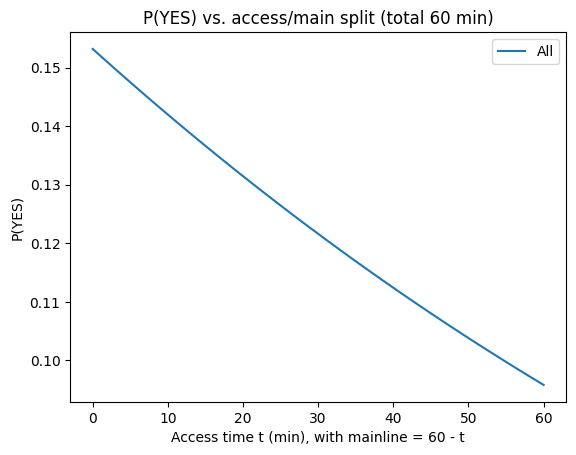

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp

# 推定済み係数
b_low  = results.get_beta_values()        # 下位（access）
b_up   = results_main.get_beta_values()   # 上位（main）

# 代表点（基準）をデータから取得
t_ref      = m_master_df["AccessTime_used[m]"].mean()        # 端末時間の平均（分）
mu_work_h  = m_master_df["WorkTime[m]"].mean()/60.0         # 時
mu_hhm     = m_master_df["HouseholdMembers(all)"].mean()
mu_logsum  = m_master_df["LOGSUM_ACCESS"].mean()

# 合計60分の基準点でのロジット（L0）
L0 = (b_up["ASC_YES"]
      + b_up["B_WORKTIME"] * mu_work_h
      + b_up["B_HHM_all"]  * mu_hhm
      + b_up["B_LOGSUM"]   * mu_logsum
      + b_up["B_MACMTIME"] * (60.0 - t_ref)/60)   # 本線は 60 - t_ref

# 端末⇄本線の1分置き換えに対する傾き（log-odds/分）
slope = b_up["B_LOGSUM"] * b_low["B_TIME_LS"] - (b_up["B_MACMTIME"]/60)

# 曲線を描く
t = np.linspace(0, 60, 121) # 端末時間（分）
L = L0 + slope * (t - t_ref)
P = 1.0 / (1.0 + np.exp(-L))

plt.figure()
plt.plot(t, P, label="All")
plt.xlabel("Access time t (min), with mainline = 60 - t")
plt.ylabel("P(YES)")
plt.title("P(YES) vs. access/main split (total 60 min)")
plt.legend(); plt.show()

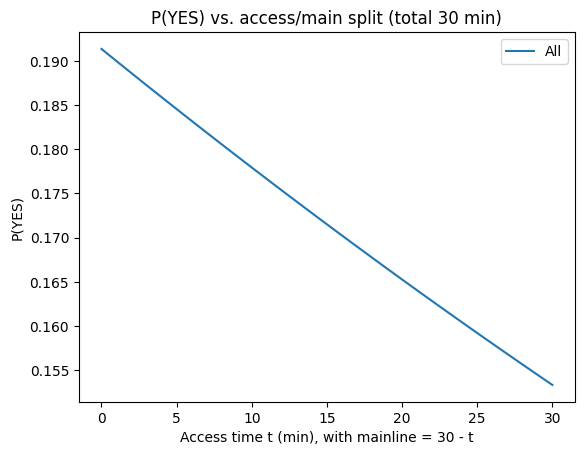

In [18]:
# 推定済み係数
b_low  = results.get_beta_values()        # 下位（access）
b_up   = results_main.get_beta_values()   # 上位（main）

# 代表点（基準）をデータから取得
t_ref      = m_master_df["AccessTime_used[m]"].mean()        # 端末時間の平均（分）
mu_work_h  = m_master_df["WorkTime[m]"].mean()/60.0         # 時
mu_hhm     = m_master_df["HouseholdMembers(all)"].mean()
mu_logsum  = m_master_df["LOGSUM_ACCESS"].mean()

# 合計60分の基準点でのロジット（L0）
L0 = (b_up["ASC_YES"]
      + b_up["B_WORKTIME"] * mu_work_h
      + b_up["B_HHM_all"]  * mu_hhm
      + b_up["B_LOGSUM"]   * mu_logsum
      + b_up["B_MACMTIME"] * (30.0 - t_ref)/60)   # 本線は 60 - t_ref

# 端末⇄本線の1分置き換えに対する傾き（log-odds/分）
slope = b_up["B_LOGSUM"] * b_low["B_TIME_LS"] - (b_up["B_MACMTIME"]/60)

# 曲線を描く
t = np.linspace(0, 30, 61) # 端末時間（分）
L = L0 + slope * (t - t_ref)
P = 1.0 / (1.0 + np.exp(-L))

plt.figure()
plt.plot(t, P, label="All")
plt.xlabel("Access time t (min), with mainline = 30 - t")
plt.ylabel("P(YES)")
plt.title("P(YES) vs. access/main split (total 30 min)")
plt.legend(); plt.show()

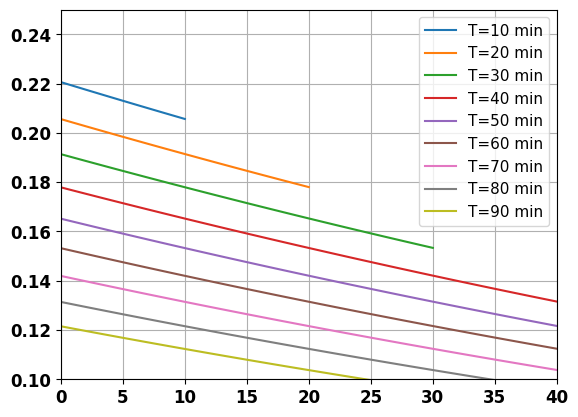

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ── 推定済み係数（下位・上位）
b_low = results.get_beta_values()          # 下位（access）
b_up  = results_main.get_beta_values()     # 上位（main）

# ── 代表値（他の共変量は固定）
t_ref     = m_master_df["AccessTime_used[m]"].mean()     # 端末（分）
mu_work_h = m_master_df["WorkTime[m]"].mean()/60.0      # 時
mu_hhm    = m_master_df["HouseholdMembers(all)"].mean()
mu_logsum = m_master_df["LOGSUM_ACCESS"].mean()         # 参照用のLOGSUM平均

# ── log-odds の傾き（/分）：端末+1分 ↔ 本線−1分
slope = b_up["B_LOGSUM"]*b_low["B_TIME_LS"] - b_up["B_MACMTIME"]/60.0

# ── T毎の切片（log-odds）
C0 = b_up["ASC_YES"] + b_up["B_WORKTIME"]*mu_work_h + b_up["B_HHM_all"]*mu_hhm
# L(t;T) = [C0 + B_LOGSUM*mu_logsum - B_LOGSUM*B_TIME_LS*t_ref + (B_MACMTIME/60)*T] + slope * t
def intercept_T(T):
    return (C0
            + b_up["B_LOGSUM"]*mu_logsum
            - b_up["B_LOGSUM"]*b_low["B_TIME_LS"]*t_ref
            + (b_up["B_MACMTIME"]/60.0)*T)

def sigmoid(z): return 1/(1+np.exp(-z))

plt.figure()
for T in range(10, 91, 10):         # T=10,20,...,90
    t = np.linspace(0, T, T+1)      # 端末は 0〜T 分
    L = intercept_T(T) + slope * t
    P = sigmoid(L)
    plt.plot(t, P, label=f"T={T} min")

plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

#plt.xlabel("Access time t (min)   (mainline = T - t)")
#plt.ylabel("P(YES)")
#plt.title("P(YES) vs. access/main split for total time T ∈ {10,…,90}")
plt.xlim(0, 40); plt.ylim(0.1, 0.25)
plt.grid(True)
plt.legend(fontsize=11); plt.show()


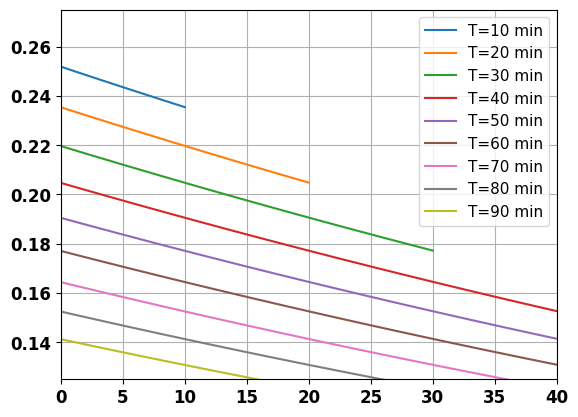

In [20]:
# 固定値の改良版（固定値に意味を持たせる）
# ── 推定済み係数（下位・上位）
b_low = results.get_beta_values()          # 下位（access）
b_up  = results_main.get_beta_values()     # 上位（main）

# ── 代表値（他の共変量は固定）
t_ref     = m_master_df["AccessTime_used[m]"].mean()     # 端末（分）
mu_work_h = m_master_df["WorkTime[m]"].mean()/60.0      # 時
mu_hhm    = 2 # 世帯人数2人
mu_lu     = 1684314.03018102 / 1e6 # 阿佐ヶ谷駅 
mu_logsum = m_master_df["LOGSUM_ACCESS"].mean()         # 参照用のLOGSUM平均

# ── log-odds の傾き（/分）：端末+1分 ↔ 本線−1分
slope = b_up["B_LOGSUM"]*b_low["B_TIME_LS"] - b_up["B_MACMTIME"]/60.0

# ── T毎の切片（log-odds）
C0 = b_up["ASC_YES"] + b_up["B_WORKTIME"]*mu_work_h + b_up["B_HHM_all"]*mu_hhm + b_up["B_N_EKI_SCORE"]*mu_lu
# L(t;T) = [C0 + B_LOGSUM*mu_logsum - B_LOGSUM*B_TIME_LS*t_ref + (B_MACMTIME/60)*T] + slope * t
def intercept_T(T):
    return (C0
            + b_up["B_LOGSUM"]*mu_logsum
            - b_up["B_LOGSUM"]*b_low["B_TIME_LS"]*t_ref
            + (b_up["B_MACMTIME"]/60.0)*T)

def sigmoid(z): return 1/(1+np.exp(-z))

plt.figure()
for T in range(10, 91, 10):         # T=10,20,...,90
    t = np.linspace(0, T, T+1)      # 端末は 0〜T 分
    L = intercept_T(T) + slope * t # 通勤時間で効用を計算して，メインと端末の差分を+以降のやつで加算している
    P = sigmoid(L)
    plt.plot(t, P, label=f"T={T} min")

plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

#plt.xlabel("Access time t (min)   (mainline = T - t)")
#plt.ylabel("P(YES)")
#plt.title("P(YES) vs. access/main split for total time T ∈ {10,…,90}")
plt.xlim(0, 40); plt.ylim(0.125, 0.275)
plt.grid(True)
plt.legend(fontsize=11); plt.show()

In [ ]:
# 実際のポイントを計算
sum_time = 30
access_time =5
L = intercept_T(sum_time) + slope * access_time
P = sigmoid(L)
print(P)



0.21210847287387563


In [ ]:
# 実際のポイントを計算
sum_times = [30, 90]
access_times = [5, 15]
for i in sum_times:
    for l in access_times:
        L = intercept_T(i) + slope * l
        P = sigmoid(L)
        print(f"総通勤時間{i}分，最寄端末{l}分の時の私事トリップ確率",P)

総通勤時間30分，最寄端末5分の時の私事トリップ確率 0.21210847287387563
総通勤時間30分，最寄端末15分の時の私事トリップ確率 0.19758609063448512
総通勤時間90分，最寄端末5分の時の私事トリップ確率 0.13595482866989386
総通勤時間90分，最寄端末15分の時の私事トリップ確率 0.12581384793875197


In [ ]:
# 感度分析のためにlogsum値の基礎統計量を表示
m_master_df["LOGSUM_ACCESS"].describe()

count    47468.000000
mean        -3.426373
std          1.908625
min        -16.393624
25%         -4.484735
50%         -3.124545
75%         -1.993242
max         -0.326167
Name: LOGSUM_ACCESS, dtype: float64